# Introduction to Ridge and Lasso Regression -- Kristofer Schobert

## Here I follow along with Thinkful's guided example of Ridge and Lasso Regression

In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Load air quality data, drop the index column and any missing data columns.
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.
trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

# Set up the regression model to predict defaults using all other
# variables as features.
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]
#print(X_train)
regr1.fit(X_train, Y_train)
print('\nR-squared simple model:')
print(regr1.score(X_train, Y_train))

#Store the parameter estimates.
origparams = np.append(regr1.coef_, regr1.intercept_)

# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
#print(X_train2)
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))

# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)
#print(newparams)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)


R-squared simple model:
0.5738784962717032

R-squared complex model:
0.5739734452059888

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.004]
 [-0.759 -0.759]
 [0.000 4157.867]
 [-0.001 553434.569]]


In [12]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

print('\nR-squared simple model:')
print(regr1.score(X_test, Y_test))

# Test the more complex model with larger coefficients.
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

# Re-run the model with the new features.
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared complex model:')
print(regrBig.score(X_test2, Y_test))



R-squared simple model:
0.5630697922503316

R-squared complex model:
0.5630239527355649


In [13]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced. Note that by convention, the
# intercept is not regularized. Since we standardized the data
# earlier, the intercept should be equal to zero and can be dropped.

ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      ' and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.573873916440288
[ 1.36988466e-02 -7.57859433e-01 -3.25298557e-04]
0.5739464289613458

Parameter Estimates for the same predictors for the small model and large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


## Ridge Coefficients vs Lambda

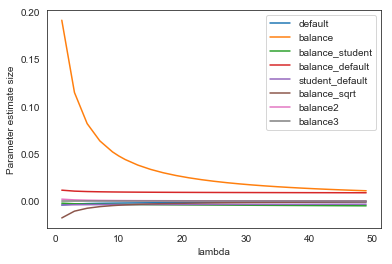

In [14]:
# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 50, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))
    #print(estimates)

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('student')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

In [15]:
# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train, Y_train)
print('R² for the model with few features:')
print(lass.score(X_train, Y_train))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.30)
lassBig.fit(X_train2, Y_train)
print('\nR² for the model with many features:')
print(lassBig.score(X_train2, Y_train))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)

R² for the model with few features:
0.450062579301185

Parameter estimates for the model with few features:
[-0.         -0.40657726 -0.          0.00114596]

R² for the model with many features:
0.4781445089581402

Parameter estimates for the model with many features:
[ 0.00000000e+00 -4.42303155e-01  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -2.95207397e-04
 -2.02390164e-07  3.15513057e+00]


## Lasso Coefficients vs Lambda

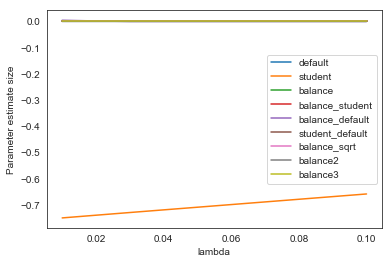

In [16]:

estimates_l = [0,0,0,0,0,0,0,0,0,0]
# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in [x / 1000.0 for x in range(10, 110, 10)]:
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates_l = np.row_stack((
        estimates_l,
        np.append(lassBig.coef_,[lambd])))
estimates_l = np.delete(estimates_l, 0, 0)
#print(estimates_l)

# Make the data pretty.
estimates_l_df = pd.DataFrame(
    estimates_l,
    columns=list(X_train2.columns) + ['lambda'])
estimates_l_df.sort_values(by='lambda', inplace=True, ascending=True)
#print(estimates_l_df)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot_l = list(estimates_l_df.columns[:9,])
#varstoplot_l.remove('student')
#varstoplot_l.remove('balance_default')
#print(varstoplot_l)

# Plot a line for each parameter.
for var in varstoplot_l:
    plt.plot(estimates_l_df['lambda'], estimates_l_df[var])
    labels.append(var)
    #print(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

The first thing I noticed was that lasso requires much smaller values for lamba. Also, many of the features's coefficients are zero or near zero with a lambda value of .01. 

The coefficient for student is largest and it is decreasing with increasing lambda. Most all the other coefficients are at zero. 

A similar plot, with the sudent coefficient removed is here:

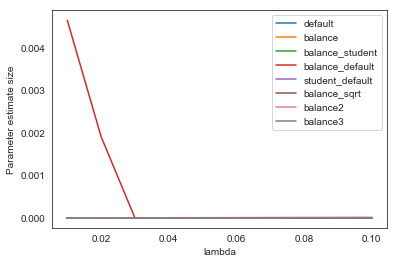

In [17]:
estimates_l = [0,0,0,0,0,0,0,0,0,0]
# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in [x / 1000.0 for x in range(10, 110, 10)]:
    lassBig = linear_model.Lasso(alpha=lambd, fit_intercept=False)
    lassBig.fit(X_train2, Y_train)
    estimates_l = np.row_stack((
        estimates_l,
        np.append(lassBig.coef_,[lambd])))
estimates_l = np.delete(estimates_l, 0, 0)
#print(estimates_l)

# Make the data pretty.
estimates_l_df = pd.DataFrame(
    estimates_l,
    columns=list(X_train2.columns) + ['lambda'])
estimates_l_df.sort_values(by='lambda', inplace=True, ascending=True)
#print(estimates_l_df)

# Leave out the 'student' variable.
# It has very high values and throws off our plot's scale.
varstoplot_l = list(estimates_l_df.columns[:9,])
varstoplot_l.remove('student')
#varstoplot_l.remove('balance_default')
#print(varstoplot_l)

# Plot a line for each parameter.
for var in varstoplot_l:
    plt.plot(estimates_l_df['lambda'], estimates_l_df[var])
    labels.append(var)
    #print(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

The coefficient of 'balance_student starts around 0.005 and heads quickly to zero. All the other coefficients are extremely close to zero. The coefficient for student is dominating.

Some striking differences of Ridge vs Lasso are the shapes of these coefficient trajectories. In Ridge Regression, they asymptotically approach zero or some other value, while in Lasso Regression they follow what looks to be straight lines to zero. 

## R^2 values for Ridge and Lasso vs Lambda

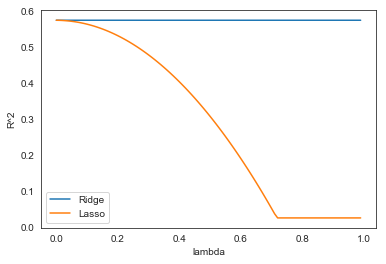

In [25]:
# Large number of parameters.
# create array to plot, col1=R^2 for ridge, col2 = R^2 fro lasso, col3 = lambda
plot_array = []

#looping through values of lambda
for lambd in list(np.arange(0, 1, 0.01)):
    #fitting the data for lasso
    lassBig = linear_model.Lasso(alpha=lambd)
    lassBig.fit(X_train2, Y_train)

    #fitting the data for ridge
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    
    #adding a row to lot array corresponding to the R^2 scores of this lambda
    plot_array.append([ridgeregrBig.score(X_train2, Y_train),lassBig.score(X_train2, Y_train),lambd])   
plot_array = np.array(plot_array)


plt.plot(plot_array[:,2],plot_array[:,0])
plt.plot(plot_array[:,2],plot_array[:,1])
plt.xlabel('lambda')
plt.ylabel('R^2')
plt.legend(['Ridge','Lasso'])


plt.show()


As we can see, the R^2 value for lasso regression changes far more drastically with lambda than does the R^2 of ridge regression. There also seems to be a critical value of about lambda = 0.7 where lasso stops decreasing. It is constant from then on. As we know lasso can take all coefficients to zero. When lambda is 0.7 all the coefficients (aside from the y-intercept) must be zero. 

The R^2 values for ridge regression is not constant. It has a negative slope and it is just very small. 

In [26]:
# viewing the array again col1 = ridge_R^2, col2 = lasso_R^2, col3=lambda
plot_array

array([[0.57397331, 0.57394445, 0.        ],
       [0.57397234, 0.5737681 , 0.01      ],
       [0.57397234, 0.57337393, 0.02      ],
       [0.57397233, 0.57275184, 0.03      ],
       [0.57397233, 0.57200873, 0.04      ],
       [0.57397232, 0.5710533 , 0.05      ],
       [0.57397231, 0.56988499, 0.06      ],
       [0.5739723 , 0.56850466, 0.07      ],
       [0.57397229, 0.56691197, 0.08      ],
       [0.57397228, 0.56510691, 0.09      ],
       [0.57397227, 0.56308949, 0.1       ],
       [0.57397225, 0.56085971, 0.11      ],
       [0.57397224, 0.55841756, 0.12      ],
       [0.57397222, 0.55576304, 0.13      ],
       [0.5739722 , 0.55289617, 0.14      ],
       [0.57397218, 0.54981692, 0.15      ],
       [0.57397216, 0.54652531, 0.16      ],
       [0.57397214, 0.54302134, 0.17      ],
       [0.57397211, 0.539305  , 0.18      ],
       [0.57397209, 0.5353763 , 0.19      ],
       [0.57397207, 0.53123523, 0.2       ],
       [0.57397204, 0.5268818 , 0.21      ],
       [0.